# Load the Game Registry

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
import time
import cv2
import os
from matplotlib.pyplot import figure
import torch
from tqdm import tqdm
import random
from PIL import Image

In [2]:
import numpy as np
from envs.game_registry import GAMES, GAME_NAMES

In [3]:
print(GAME_NAMES)

dict_keys(['SimpleExplorationGame', 'SimpleExplorationGameStochastic'])


# Load Latent Data

In [4]:
experiment_name = 'random_walk_300k_4_action_pos'
LOAD_DIR = None # TODO: Set path.
EXP_DIR = os.path.join(LOAD_DIR, experiment_name)
OBS_DIR = os.path.join(EXP_DIR, 'obs')
POS_DIR = os.path.join(EXP_DIR, 'pos')
MAP_DIR = os.path.join(EXP_DIR, 'maps')
LOG_DIR = os.path.join(EXP_DIR, 'logs')
LATENT_DIR = os.path.join(EXP_DIR, 'latents')

latent_block_path = os.path.join(LATENT_DIR, 'latents_block.npy')
position_block_path = os.path.join(POS_DIR, 'pos_block.npy')

In [5]:
latents_block = np.load(latent_block_path)
positions_block = np.load(position_block_path)

In [6]:
# latent_path = os.path.join(LATENT_DIR, 'latents.npz')
# latents = np.load(latent_path)
# latent_list = [latents[key] for key in tqdm(list(latents.keys()))]

In [7]:
# latents_block = np.concatenate(latent_list)

# Create the position data block

In [8]:
# from glob import glob
# position_paths = sorted(glob(POS_DIR + '/*'))

In [9]:
# position_list = [np.load(path) for path in tqdm(position_paths)]

In [10]:
# positions_block = np.stack(position_list)

In [11]:
# with open(os.path.join(POS_DIR, 'pos_block.npy'), 'wb') as f:
#     np.save(f, positions_block)

# Create the Environment

In [12]:
from envs.vizdoom_env import VizdoomEnv

In [13]:
env = VizdoomEnv('SimpleExplorationGame')

# Create the Agent

In [14]:
from agents.mpc_model import MPCModel
from agents.mpc_agent_graph import MPCAgent

In [15]:
MODEL_PATH = None # TODO: Set path.

default_config = {
    'max_lookahead': 6,
    'num_actions': 4,
    'input_channels': 12,
    'spatial_size': (120,160),
    'backbone_name': 'resnet18',
    'backbone_output_dim': 512,
    'fc_dim': 512,
    'horizon': 6,
    'max_num_mpc_samples': 100000,
    'allT_or_lastT': 'lastT',
    'cons_or_nocons': 'nocons',
    'statH_or_dynH': 'dynH',
    'allH_or_lastH': 'lastH',
    'consistency_threshold': np.log(0.4),
    'GRAPH_EXP_DIR': None, # TODO: Set path.
    'num_nodes_graph': 500,
    'pT_distance_threshold': 4.5,
    'latent_distance_threshold': 1.5,
    'overlap_pT_distance_threshold': 4,
    'overlap_latent_distance_threshold': 2,
    'overlap_retrieval_distance_threshold': 1,
    'pT_search_threshold': 5.5,
    'graph_rng_seed': 285,
}

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MPCModel(device, config=default_config)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
agent = MPCAgent(model, device, env, config=default_config)

Setting pT distances...


100%|██████████| 500/500 [00:01<00:00, 379.75it/s]


Setting latent distances...


100%|██████████| 100/100 [00:02<00:00, 45.73it/s]


Setting retrieval distances...


100%|██████████| 500/500 [00:09<00:00, 51.28it/s]


Building unfiltered graph...


100%|██████████| 500/500 [00:00<00:00, 6387.58it/s]


Building filtered graph...


100%|██████████| 500/500 [00:00<00:00, 1952.08it/s]


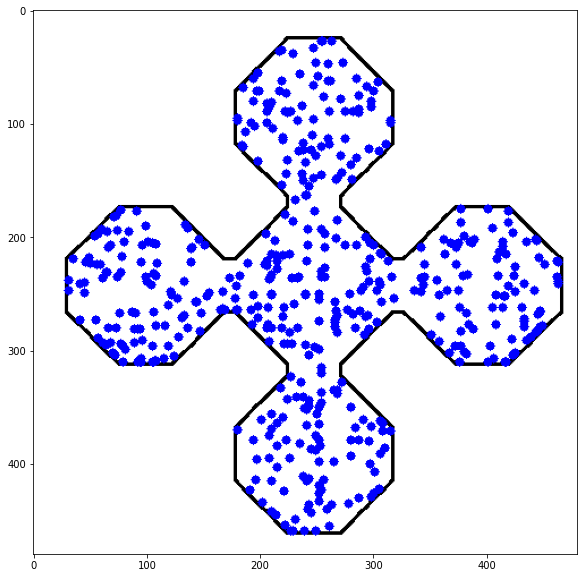

In [17]:
agent.graph_memory.render_graph_nodes()

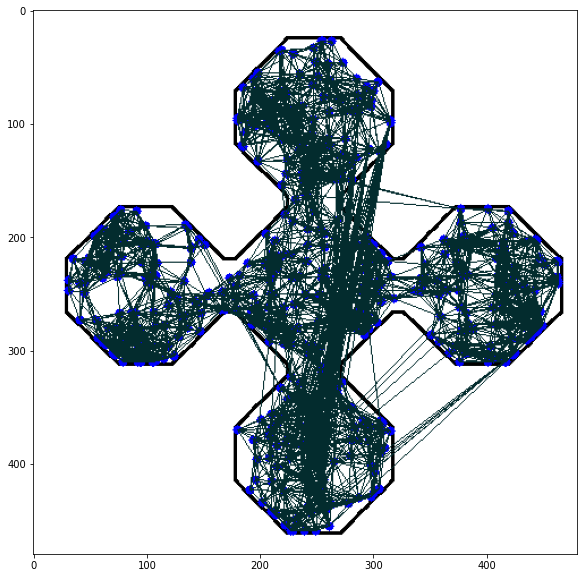

In [18]:
agent.graph_memory.render_unfiltered_graph()

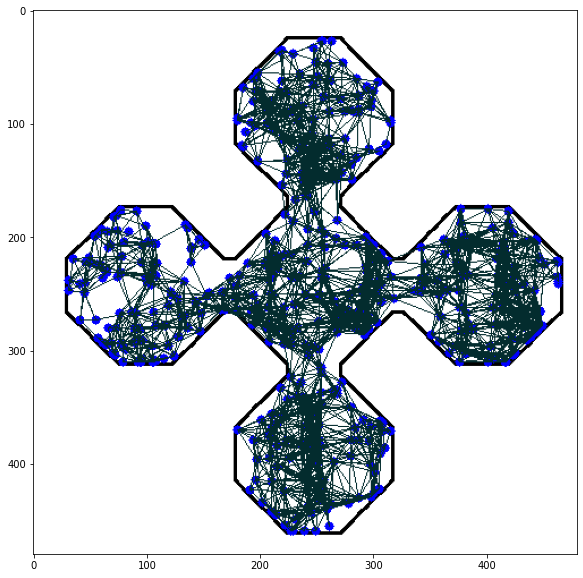

In [19]:
agent.graph_memory.render_filtered_graph()

# Get a Random Image

In [20]:
# Get a random image
env.reset()
env.game.reset_game_random_spawn()
goal_position= env.game.agent_positions[0]
goal_image = env.game.imgs

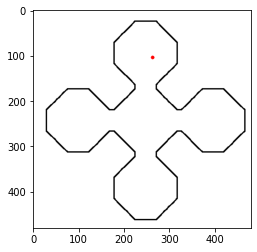

In [21]:
plt.imshow(env.game.map)

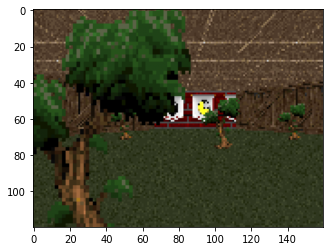

In [22]:
plt.imshow((env.game.imgs[3]/255).transpose(1,2,0))

In [23]:
# Get a random image
env.reset()
env.game.reset_game_random_spawn()
start_position= env.game.agent_positions[0]
start_image = env.game.imgs

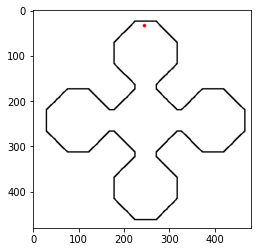

In [24]:
plt.imshow(env.game.map)

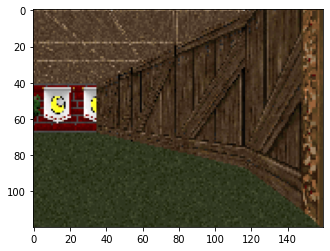

In [25]:
plt.imshow((env.game.imgs[3]/255).transpose(1,2,0))

# Graph Expansion Tests

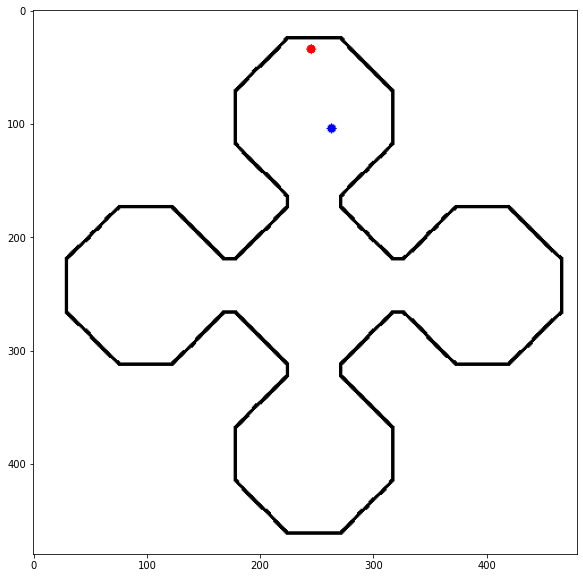

In [26]:
env.game.draw_vis_map()
env.game.draw_points([start_position, goal_position], colors=[(255, 0, 0), (0, 0, 255)])
figure(figsize=(10, 10))
plt.imshow(env.game.vis_map)

In [27]:
start_latent = agent.get_latent(start_image).cpu().numpy()
goal_latent = agent.get_latent(goal_image).cpu().numpy()

In [28]:
start_latent.shape

(1, 520)

In [29]:
t_0 = time.time()
agent.graph_memory.insert_goal_node(goal_latent, goal_position)
print(time.time() - t_0)

0.012288808822631836


In [30]:
t_0 = time.time()
agent.graph_memory.insert_start_node(start_latent, start_position)
print(time.time() - t_0)

0.007906913757324219


In [31]:
path = agent.graph_memory.shortest_path(agent.graph_memory.filtered_graph_expanded, 'start', 'goal')
path

['start', 258, 116, 'goal']

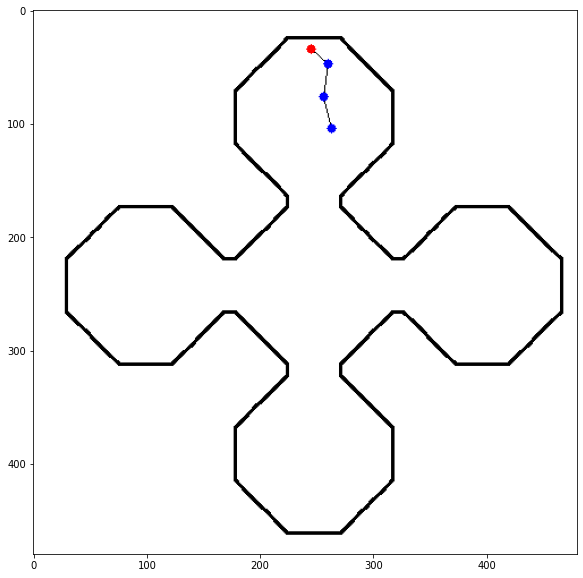

In [32]:
agent.graph_memory.render_path(path)

In [33]:
stitched_path = agent.graph_memory.stitch_path(path)
stitched_path

['start',
 37073,
 37074,
 37075,
 109798,
 50163,
 50164,
 50165,
 52090,
 265763,
 265764,
 265765,
 265766,
 'goal']

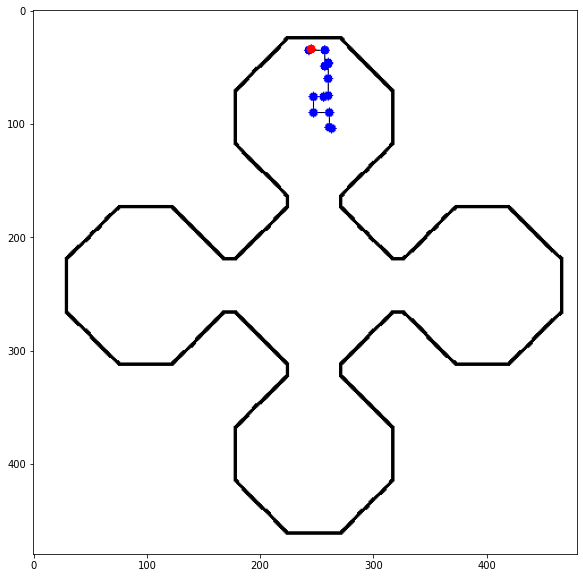

In [34]:
agent.graph_memory.render_stitched_path(stitched_path)